In [1]:
import os

DATA_DIRECTORY = '/home/younes'
LIVEJOURNAL_FILENAME = os.path.join(DATA_DIRECTORY, 'soc-LiveJournal1.txt.gz')
LIVEJOURNAL_URL = 'http://snap.stanford.edu/data/soc-LiveJournal1.txt.gz'

# Constants for you to change



# Just have these hardcoded, though we don't really need to
NUM_EDGES = 68993773
NUM_NODES = 4847571


In [2]:
# Downloading the file
import urllib.request

assert os.path.exists(DATA_DIRECTORY)

# Get your data. This file is ~250M so it will take a bit
print('DOWNLOADING 250M FILE. WILL SAVE FOR FUTURE USE')
if not os.path.exists(LIVEJOURNAL_FILENAME):
    urllib.request.urlretrieve(LIVEJOURNAL_URL, LIVEJOURNAL_FILENAME)

# Show a little bit of the file
print('\nFILE STATS:')
!ls -lh $LIVEJOURNAL_FILENAME
print('\nSTARTING LINES')
!zcat $LIVEJOURNAL_FILENAME | head -n 30

DOWNLOADING 250M FILE. WILL SAVE FOR FUTURE USE

FILE STATS:
-rw-rw-r-- 1 younes younes 248M ماي 14 02:59 /home/younes/soc-LiveJournal1.txt.gz

STARTING LINES
# Directed graph (each unordered pair of nodes is saved once): soc-LiveJournal1.txt 
# Directed LiveJournal friednship social network
# Nodes: 4847571 Edges: 68993773
# FromNodeId	ToNodeId
0	1
0	2
0	3
0	4
0	5
0	6
0	7
0	8
0	9
0	10
0	11
0	12
0	13
0	14
0	15
0	16
0	17
0	18
0	19
0	20
0	21
0	22
0	23
0	24
0	25
0	26

gzip: stdout: Broken pipe


In [3]:
# Cleaning the data

import numpy as np
import gzip

def row_generator():
    """This will generate all the edges in the graph."""
    with gzip.open(LIVEJOURNAL_FILENAME, 'rt') as f:
        for line in f:
            if line.startswith('#'):
                continue
            else:
                (left_node, right_node) = line.split('\t')
                yield(int(left_node), int(right_node))

def to_undirected(edge_iterable, num_edges, num_nodes, shuffle=True):
    """Takes an iterable of edges and produces the list of edges for the undirected graph.
    
    > to_undirected([[0,1],[1,2],[2,10]], 3, 11)
    array([[ 0,  1],
       [ 1,  0],
       [ 1,  2],
       [ 2,  1],
       [ 2, 10],
       [10,  2]])
    """
    # need int64 to do gross bithacks
    as_array = np.zeros((num_edges, 2), dtype=np.int64)
    for (i, (n_0, n_1)) in enumerate(edge_iterable):
            as_array[i,0] = n_0
            as_array[i,1] = n_1
    # The graph is directed, but we want to make it undirected,
    # which means we will duplicate some rows.

    left_nodes = as_array[:,0]
    right_nodes = as_array[:,1]
    
    if shuffle:
        the_shuffle = np.arange(num_nodes)
        np.random.shuffle(the_shuffle)
        left_nodes = the_shuffle.take(left_nodes)
        right_nodes = the_shuffle.take(right_nodes)

    
    # numpy.unique will not unique whole rows, so this little bit-hacking
    # is a quick way to get unique rows after making a flipped copy of
    # each edge.
    max_bits = int(np.ceil(np.log2(num_nodes + 1)))
    
    encoded_edges_forward = np.left_shift(left_nodes, max_bits) | right_nodes
    
    # Flip the columns and do it again:
    encoded_edges_reverse = np.left_shift(right_nodes, max_bits) | left_nodes

    unique_encoded_edges = np.unique(np.hstack((encoded_edges_forward, encoded_edges_reverse)))
    
    left_node_decoded = np.right_shift(unique_encoded_edges, max_bits)
    
    # Mask out the high order bits
    right_node_decoded = (2 ** (max_bits) - 1) & unique_encoded_edges
    
    undirected_edges = np.vstack((left_node_decoded, right_node_decoded)).T.astype(np.int32)

    # ascontiguousarray so that it's c-contiguous for cython code below
    return np.ascontiguousarray(undirected_edges)


def get_clean_data(shuffle=True):
    if shuffle:
        name = os.path.join(DATA_DIRECTORY, 'LJ-cleaned-shuffle.npy')
    else:
        name = os.path.join(DATA_DIRECTORY, 'LJ-cleane.npy')

    if os.path.exists(name):
        print('Loading from file {}'.format(name))
        return np.load(name)
    else:
        print('Parsing from zip. Will write to file {}'.format(name), flush=True)
        # Lets get the edges into one big array
        edges = to_undirected(row_generator(), NUM_EDGES, NUM_NODES, shuffle=shuffle)
        print('ORIGINAL DIST: {} MIN: {} MAX: {}'.format(np.abs(edges[:,0] - edges[:,1]).mean(), edges.min(), edges.max()))
        np.save(name, edges)
        return edges

In [4]:
print("Normalizing data (or loaded pre-computed)")
%time edges = get_clean_data(shuffle=True)
%time unshuffled_edges = get_clean_data(shuffle=False)
print('\nEDGES SHAPE: {}'.format(edges.shape))

Normalizing data (or loaded pre-computed)
Loading from file /home/younes/LJ-cleaned-shuffle.npy
CPU times: user 30.1 ms, sys: 535 ms, total: 565 ms
Wall time: 11.6 s
Loading from file /home/younes/LJ-cleane.npy
CPU times: user 25.8 ms, sys: 645 ms, total: 670 ms
Wall time: 12.1 s

EDGES SHAPE: (86220856, 2)


In [5]:
def score(assignment, edges):
    """Compute the score given an assignment of vertices.
    
    N nodes are assigned to clusters 0 to K-1.
    
    assignment: Vector where N[i] is the cluster node i is assigned to.
    edges: The edges in the graph, assumed to have one in each direction
    
    Returns: (total wasted bin space, ratio of edges cut)
    """
    balance = np.bincount(assignment) / len(assignment)
    waste = (np.max(balance) - balance).sum()
    
    left_edge_assignment = assignment.take(edges[:,0])
    right_edge_assignment = assignment.take(edges[:,1])
    mismatch = (left_edge_assignment != right_edge_assignment).sum()
    cut_ratio = mismatch / len(edges)
    return (waste, cut_ratio)

In [6]:
%load_ext cython
%pylab inline



Populating the interactive namespace from numpy and matplotlib


In [7]:
%%cython
import numpy as np
cimport cython

cdef int UNMAPPED = -1

def linear_deterministic_greedy(int[:,::] edges,
                                int num_nodes,
                                int num_partitions,
                                int[::] partition):
    """
    This algorithm favors a cluster if it has many neighbors of a node, but
    penalizes the cluster if it is close to capacity.
    
    edges: An [:,2] array of edges.
    num_nodes: The number of nodes in the graph.
    num_partitions: How many partitions we are breaking the graph into.
    partition: The partition from a previous run. Used for restreaming.

    Returns: A new partition.
    """
    # The output partition

    if partition is None:
        partition = np.repeat(np.int32(UNMAPPED), num_nodes)

    cdef int[::] partition_sizes = np.zeros(num_partitions, dtype=np.int32)
         
    cdef int[::] partition_votes = np.zeros(num_partitions, dtype=np.int32)
    
    # Fine to be a little off, to stay integers
    cdef int partition_capacity = num_nodes / num_partitions
    
    cdef int last_left = edges[0,0]
    cdef int i = 0
    cdef int left = 0
    cdef int right = 0
    cdef int arg = 0
    cdef int max_arg = 0
    cdef int max_val = 0
    cdef int val = 0
    cdef int len_edges = len(edges)
    
    for i in range(len_edges):
        left = edges[i,0]
        right = edges[i,1]
    
        if last_left != left:
            # We have found a new node so assign last_left to a partition
                
            max_arg = 0
            max_val = (partition_votes[0]) * (
                       partition_capacity - partition_sizes[0])

            for arg in range(1, num_partitions):
                val = (partition_votes[arg]) * (
                       partition_capacity - partition_sizes[arg])
                if val > max_val:
                    max_arg = arg
                    max_val = val

            if max_val == 0:
                max_arg = arg
                # No neighbors (or multiple maxed out) so "randomly" select
                # the smallest partition
                for arg in range(i % num_partitions, num_partitions):
                    if partition_sizes[arg] < partition_capacity:
                        max_arg = arg
                        max_val = 1
                        break
                if max_val == 0:
                    for arg in range(0, i % num_partitions):
                        if partition_sizes[arg] < partition_capacity:
                            max_arg = arg
                            break


            partition_sizes[max_arg] += 1
            partition[last_left] = max_arg
            partition_votes[:] = 0
            last_left = left

        if partition[right] != UNMAPPED:
            partition_votes[partition[right]] += 1


    # Clean up the last assignment
    max_arg = 0
    max_val = 0
    for arg in range(0, num_partitions):
        if partition_sizes[arg] < partition_capacity:
            val = (partition_votes[arg]) * (
                    1 - partition_sizes[arg] / partition_capacity)
            if val > max_val:
                max_arg = arg
                max_val = val
    partition[left] = max_arg

    return np.asarray(partition)

In [8]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 2, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 4.1 s, sys: 25.8 ms, total: 4.12 s
Wall time: 4.11 s
edge score:0.20469669194655177 waste: 2.0628888153240155e-07


In [9]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 4, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 4.06 s, sys: 27.9 ms, total: 4.09 s
Wall time: 4.07 s
edge score:0.31586594315417144 waste: 1.0314444078840523e-06


In [10]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 8, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 4.25 s, sys: 15 ms, total: 4.27 s
Wall time: 4.25 s
edge score:0.4101830536222002 waste: 2.6817554605595983e-06


In [11]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 16, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 4.54 s, sys: 43.1 ms, total: 4.59 s
Wall time: 4.56 s
edge score:0.49411077523980973 waste: 5.982377565952324e-06


In [12]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 32, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 4.89 s, sys: 9.45 ms, total: 4.9 s
Wall time: 4.88 s
edge score:0.5447075589228666 waste: 0.00011490290704350287


In [13]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 40, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 4.94 s, sys: 19.3 ms, total: 4.96 s
Wall time: 4.93 s
edge score:0.5491682662023212 waste: 8.02463749371568e-05


In [19]:
def draw_figures(waste_values, edge_score_values, num_partitions):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    
    (waste_axes, score_axes) = axes
    waste_axes.plot(waste_values, 'r')
    waste_axes.set_xlabel('Round')
    waste_axes.set_ylabel('Number of wasted bins')
    waste_axes.set_ylim(bottom=0)
    waste_axes.set_title('Wasted Bins: {} partitions'.format(num_partitions))
    
    score_axes.plot(edge_score_values, 'r')
    score_axes.set_xlabel('Round')
    score_axes.set_ylabel('ratio of edge cut')
    score_axes.set_ylim(bottom=0)
    score_axes.set_title('Score: {} partitions'.format(num_partitions))
    
    fig.tight_layout()

In [20]:
def run_restreaming_greedy(edges, num_nodes, num_partitions=10, num_iterations=10):
    print('\n{} PARTITIONS'.format(num_partitions))
    assignments = None
    print('ROUND\tWASTE\tSCORE')
    waste_values = []
    edge_score_values = []
    flipped_edges = numpy.flipud(edges).copy()
    for i in range(num_iterations):
        assignments = linear_deterministic_greedy(edges, NUM_NODES, num_partitions, assignments)
        (waste, edge_score) = score(assignments, edges)
        waste_values.append(waste)
        edge_score_values.append(edge_score)
        print('{}\t{:0.3f}\t{:0.3f}'.format(i, waste, edge_score))
    draw_figures(waste_values, edge_score_values, num_partitions)
# Use the greedy method to break into 4 partitions


2 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.205
1	0.000	0.167
2	0.000	0.145
3	0.000	0.136
4	0.000	0.131
5	0.000	0.129
6	0.000	0.127
7	0.000	0.126
8	0.000	0.124
9	0.000	0.124
10	0.000	0.123
11	0.000	0.123
12	0.000	0.122
13	0.000	0.122
14	0.000	0.121
15	0.000	0.121
16	0.000	0.120
17	0.000	0.121
18	0.000	0.120
19	0.000	0.120
CPU times: user 2min 44s, sys: 12.9 s, total: 2min 57s
Wall time: 2min 57s


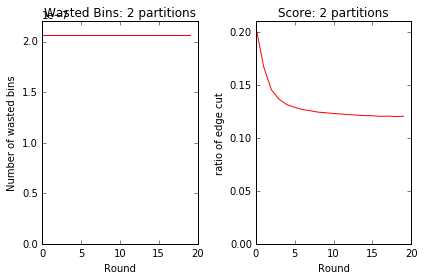

In [21]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=2, num_iterations=20)



4 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.316
1	0.000	0.227
2	0.000	0.209
3	0.000	0.200
4	0.000	0.194
5	0.000	0.190
6	0.000	0.188
7	0.000	0.186
8	0.000	0.184
9	0.000	0.183
10	0.000	0.182
11	0.000	0.181
12	0.000	0.180
13	0.000	0.180
14	0.000	0.179
15	0.000	0.179
16	0.000	0.178
17	0.000	0.178
18	0.000	0.178
19	0.000	0.178
CPU times: user 2min 50s, sys: 13.2 s, total: 3min 3s
Wall time: 3min 3s


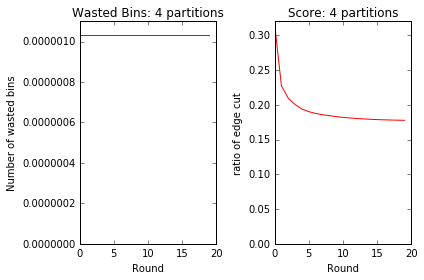

In [22]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=4, num_iterations=20)



8 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.410
1	0.000	0.305
2	0.000	0.279
3	0.000	0.266
4	0.000	0.259
5	0.000	0.255
6	0.000	0.252
7	0.000	0.250
8	0.000	0.248
9	0.000	0.247
10	0.000	0.246
11	0.000	0.245
12	0.000	0.244
13	0.000	0.244
14	0.000	0.243
15	0.000	0.243
16	0.000	0.242
17	0.000	0.242
18	0.000	0.241
19	0.000	0.241
CPU times: user 2min 54s, sys: 13.9 s, total: 3min 8s
Wall time: 3min 8s


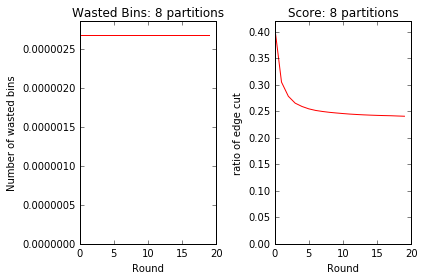

In [23]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=8, num_iterations=20)



16 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.494
1	0.000	0.400
2	0.000	0.368
3	0.000	0.357
4	0.000	0.350
5	0.000	0.346
6	0.000	0.343
7	0.000	0.341
8	0.000	0.339
9	0.000	0.337
10	0.000	0.336
11	0.000	0.335
12	0.000	0.335
13	0.000	0.334
14	0.000	0.334
15	0.000	0.333
16	0.000	0.333
17	0.000	0.333
18	0.000	0.332
19	0.000	0.332
CPU times: user 2min 53s, sys: 12.8 s, total: 3min 6s
Wall time: 3min 5s


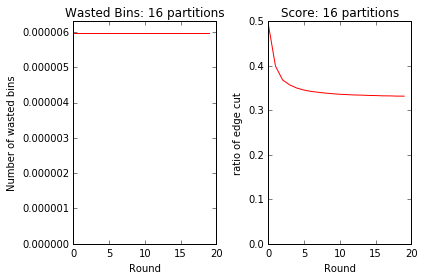

In [24]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=16, num_iterations=20)



32 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.545
1	0.000	0.447
2	0.000	0.411
3	0.000	0.397
4	0.000	0.391
5	0.000	0.386
6	0.000	0.383
7	0.000	0.381
8	0.000	0.379
9	0.000	0.378
10	0.000	0.376
11	0.000	0.374
12	0.000	0.374
13	0.000	0.373
14	0.000	0.373
15	0.000	0.371
16	0.000	0.370
17	0.000	0.369
18	0.000	0.368
19	0.000	0.368
CPU times: user 2min 57s, sys: 13.6 s, total: 3min 11s
Wall time: 3min 10s


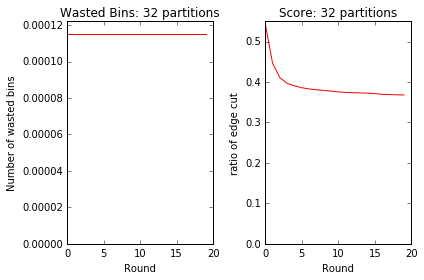

In [25]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=32, num_iterations=20)



40 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.549
1	0.000	0.453
2	0.000	0.413
3	0.000	0.405
4	0.000	0.395
5	0.000	0.390
6	0.000	0.387
7	0.000	0.385
8	0.000	0.383
9	0.000	0.382
10	0.000	0.380
11	0.000	0.379
12	0.000	0.378
13	0.000	0.378
14	0.000	0.377
15	0.000	0.377
16	0.000	0.377
17	0.000	0.377
18	0.000	0.377
19	0.000	0.376
CPU times: user 2min 58s, sys: 13 s, total: 3min 11s
Wall time: 3min 10s


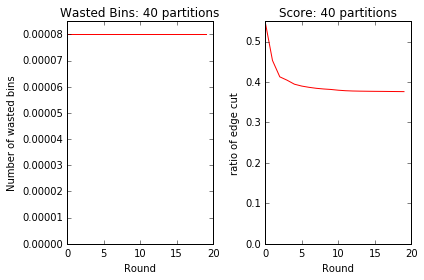

In [26]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=40, num_iterations=20)


In [27]:
%%cython
import numpy as np

cdef int UNMAPPED = -1

def fennel(int[:,::] edges,
           int num_nodes,
           int num_partitions,
           int[::] partition,
           float alpha):
    """
    This algorithm favors a cluster if it has many neighbors of a node, but
    penalizes the cluster if it is close to capacity.
    
    partition: A previous partition of the nodes. Set to -1's if a node has not been assigned.
    """
    
    cdef int[::] partition_sizes = None
    # The output partition
    if partition is None:
        partition = np.repeat(np.int32(UNMAPPED), num_nodes)
        partition_sizes = np.zeros(num_partitions, dtype=np.int32)
    else:
        partition_sizes = np.bincount(partition).astype(np.int32)
    
    cdef int[::] partition_votes = np.zeros(num_partitions, dtype=np.int32)
    
    cdef float partition_capacity = num_nodes / num_partitions
    
    cdef int last_left = edges[0,0]
    cdef int i = 0
    cdef int left = 0
    cdef int right = 0
    cdef int arg = 0
    cdef int max_arg = 0
    cdef float max_val = 0
    cdef float val = 0
    cdef int len_edges = len(edges)
    cdef int previous_assignment = 0

    for i in range(len_edges):
        left = edges[i,0]
        right = edges[i,1]
    
        if last_left != left:
            # New left node, so we have to assign last left

            # Remember placement of last_left in the previous assignment
            previous_assignment = partition[last_left]
            
            max_arg = 0
            max_val = partition_votes[0] - alpha * partition_sizes[0]
            if previous_assignment == 0:
                # We remove the node from its current partition before
                # deciding to re-add it, so subtract alpha to give
                # result of 1 lower partition size.
                max_val += alpha

            for arg in range(1, num_partitions):
                val = partition_votes[arg] - alpha * partition_sizes[arg]
                if previous_assignment == arg:
                    # See comment above
                    val += alpha
                if val > max_val:
                    max_arg = arg
                    max_val = val

            if max_arg != previous_assignment:
                partition[last_left] = max_arg
                partition_sizes[max_arg] += 1
                if previous_assignment != UNMAPPED:
                    partition_sizes[previous_assignment] -= 1

            partition_votes[:] = 0
            last_left = left

        if partition[right] != -1:
            partition_votes[partition[right]] += 1
    
    # TODO: finish off this fencepost....
    partition[left] = 0
    
    return np.asarray(partition)

In [23]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,2,assignment,5.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 4.43 s, sys: 8.55 ms, total: 4.43 s
Wall time: 4.42 s
wast=1.0000002062888815 edge cut = 0.23604469897631264


In [24]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,2,assignment,1.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 4.44 s, sys: 8.79 ms, total: 4.45 s
Wall time: 4.43 s
wast=1.0000002062888815 edge cut = 0.23770582839029109


In [25]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,2,assignment,2.000000125)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 4.41 s, sys: 4.54 ms, total: 4.41 s
Wall time: 4.4 s
wast=1.0000002062888815 edge cut = 0.20999568828219473


In [26]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,2,assignment,2.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 4.4 s, sys: 15.9 ms, total: 4.42 s
Wall time: 4.4 s
wast=1.0000002062888815 edge cut = 0.20999568828219473


In [27]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,4,assignment,2.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 4.36 s, sys: 23.9 ms, total: 4.38 s
Wall time: 4.37 s
wast=1.0000002062888815 edge cut = 0.3804908872628219


In [28]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,8,assignment,2.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 4.62 s, sys: 19.7 ms, total: 4.64 s
Wall time: 4.62 s
wast=1.0000026817554606 edge cut = 0.4375627632367742


In [29]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,16,assignment,2.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 4.84 s, sys: 8.49 ms, total: 4.85 s
Wall time: 4.83 s
wast=1.0000092829996714 edge cut = 0.49960230039933723


In [30]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,32,assignment,2.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 4.89 s, sys: 30.6 ms, total: 4.92 s
Wall time: 4.91 s
wast=1.0000158842438822 edge cut = 0.5766571373404134


In [31]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,40,assignment,2.)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 5.23 s, sys: 23.1 ms, total: 5.25 s
Wall time: 5.23 s
wast=1.0000719948196737 edge cut = 0.5595745651145009


In [28]:
def run_fennel_restreaming(edges, num_nodes, num_partitions, num_iterations):
    print('{} PARTITIONS'.format(num_partitions))
    assignments = None
    # We will explore this parameter in a future post. This is sub-optimal
    alphas = np.linspace(1.251608191745264e-07, 7.588951557309824e-03, num_iterations)
    waste_scores, edge_score_values = [], []
    print('ROUND\tALPHA\tWASTE\tSCORE')
    for i in range(num_iterations):
        alpha = alphas[i]
        assignments = fennel(edges, NUM_NODES, num_partitions, assignments, alpha)
        (waste, edge_score) = score(assignments, edges)
        print('{}\t{:.1e}\t{:0.3f}\t{:0.3f}'.format(i, alpha, waste, edge_score))
        waste_scores.append(waste)
        edge_score_values.append(edge_score)
    draw_figures(waste_scores, edge_score_values, num_partitions)

2 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.000	0.249
1	4.0e-04	0.001	0.159
2	8.0e-04	0.000	0.128
3	1.2e-03	0.000	0.114
4	1.6e-03	0.000	0.105
5	2.0e-03	0.000	0.099
6	2.4e-03	0.000	0.095
7	2.8e-03	0.000	0.092
8	3.2e-03	0.000	0.089
9	3.6e-03	0.000	0.086
10	4.0e-03	0.000	0.084
11	4.4e-03	0.000	0.083
12	4.8e-03	0.000	0.082
13	5.2e-03	0.000	0.081
14	5.6e-03	0.000	0.081
15	6.0e-03	0.000	0.080
16	6.4e-03	0.000	0.080
17	6.8e-03	0.000	0.080
18	7.2e-03	0.000	0.080
19	7.6e-03	0.000	0.079
CPU times: user 2min 59s, sys: 13.8 s, total: 3min 13s
Wall time: 3min 12s


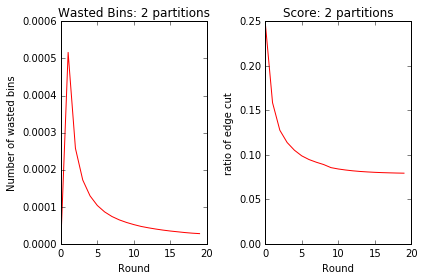

In [29]:
%time run_fennel_restreaming(edges, NUM_NODES, 2, 20)


4 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.002	0.320
1	4.0e-04	0.001	0.220
2	8.0e-04	0.001	0.195
3	1.2e-03	0.001	0.183
4	1.6e-03	0.000	0.175
5	2.0e-03	0.000	0.170
6	2.4e-03	0.000	0.166
7	2.8e-03	0.000	0.164
8	3.2e-03	0.000	0.162
9	3.6e-03	0.000	0.160
10	4.0e-03	0.000	0.159
11	4.4e-03	0.000	0.158
12	4.8e-03	0.000	0.158
13	5.2e-03	0.000	0.157
14	5.6e-03	0.000	0.157
15	6.0e-03	0.000	0.156
16	6.4e-03	0.000	0.156
17	6.8e-03	0.000	0.156
18	7.2e-03	0.000	0.155
19	7.6e-03	0.000	0.155
CPU times: user 3min 4s, sys: 13.8 s, total: 3min 17s
Wall time: 3min 17s


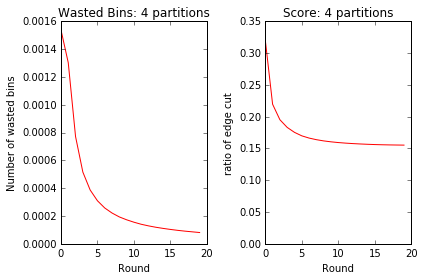

In [30]:
%time run_fennel_restreaming(edges, NUM_NODES, 4, 20)


8 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.025	0.411
1	4.0e-04	0.003	0.282
2	8.0e-04	0.001	0.256
3	1.2e-03	0.001	0.245
4	1.6e-03	0.001	0.237
5	2.0e-03	0.001	0.232
6	2.4e-03	0.001	0.228
7	2.8e-03	0.000	0.224
8	3.2e-03	0.000	0.219
9	3.6e-03	0.000	0.217
10	4.0e-03	0.000	0.214
11	4.4e-03	0.001	0.212
12	4.8e-03	0.001	0.210
13	5.2e-03	0.000	0.209
14	5.6e-03	0.000	0.208
15	6.0e-03	0.000	0.207
16	6.4e-03	0.000	0.206
17	6.8e-03	0.000	0.206
18	7.2e-03	0.000	0.205
19	7.6e-03	0.000	0.205
CPU times: user 3min 4s, sys: 13.6 s, total: 3min 18s
Wall time: 3min 17s


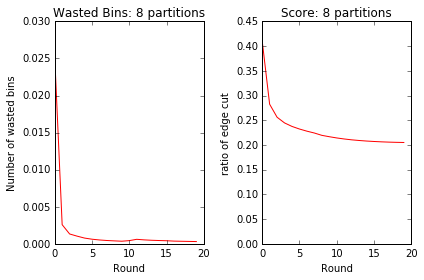

In [31]:
%time run_fennel_restreaming(edges, NUM_NODES, 8, 20)


16 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.362	0.445
1	4.0e-04	0.008	0.343
2	8.0e-04	0.004	0.308
3	1.2e-03	0.002	0.294
4	1.6e-03	0.002	0.286
5	2.0e-03	0.001	0.281
6	2.4e-03	0.002	0.277
7	2.8e-03	0.002	0.274
8	3.2e-03	0.002	0.272
9	3.6e-03	0.002	0.270
10	4.0e-03	0.001	0.268
11	4.4e-03	0.001	0.267
12	4.8e-03	0.001	0.266
13	5.2e-03	0.001	0.265
14	5.6e-03	0.001	0.264
15	6.0e-03	0.001	0.263
16	6.4e-03	0.001	0.263
17	6.8e-03	0.001	0.262
18	7.2e-03	0.001	0.262
19	7.6e-03	0.001	0.261
CPU times: user 3min 4s, sys: 13.4 s, total: 3min 17s
Wall time: 3min 17s


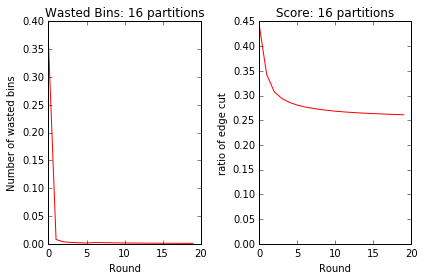

In [32]:
%time run_fennel_restreaming(edges, NUM_NODES, 16, 20)


32 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	1.120	0.476
1	4.0e-04	0.015	0.404
2	8.0e-04	0.007	0.362
3	1.2e-03	0.010	0.345
4	1.6e-03	0.008	0.334
5	2.0e-03	0.027	0.327
6	2.4e-03	0.048	0.321
7	2.8e-03	0.043	0.317
8	3.2e-03	0.036	0.315
9	3.6e-03	0.031	0.313
10	4.0e-03	0.027	0.311
11	4.4e-03	0.023	0.310
12	4.8e-03	0.021	0.309
13	5.2e-03	0.018	0.308
14	5.6e-03	0.017	0.308
15	6.0e-03	0.015	0.307
16	6.4e-03	0.014	0.307
17	6.8e-03	0.013	0.306
18	7.2e-03	0.011	0.306
19	7.6e-03	0.011	0.306
CPU times: user 3min 10s, sys: 13.2 s, total: 3min 23s
Wall time: 3min 22s


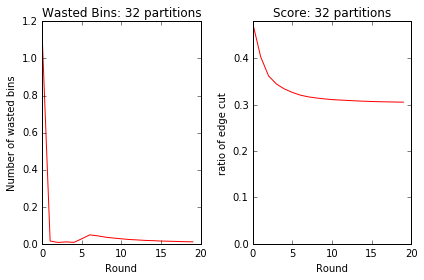

In [33]:
%time run_fennel_restreaming(edges, NUM_NODES, 32, 20)


40 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	1.777	0.465
1	4.0e-04	0.017	0.413
2	8.0e-04	0.009	0.369
3	1.2e-03	0.050	0.353
4	1.6e-03	0.107	0.343
5	2.0e-03	0.085	0.340
6	2.4e-03	0.066	0.338
7	2.8e-03	0.052	0.337
8	3.2e-03	0.043	0.336
9	3.6e-03	0.036	0.335
10	4.0e-03	0.031	0.334
11	4.4e-03	0.027	0.334
12	4.8e-03	0.024	0.333
13	5.2e-03	0.022	0.333
14	5.6e-03	0.021	0.332
15	6.0e-03	0.020	0.332
16	6.4e-03	0.019	0.331
17	6.8e-03	0.018	0.331
18	7.2e-03	0.017	0.331
19	7.6e-03	0.017	0.330
CPU times: user 3min 12s, sys: 13.4 s, total: 3min 25s
Wall time: 3min 25s


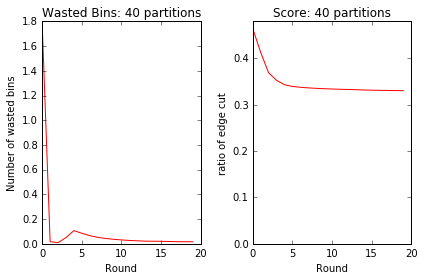

In [34]:
%time run_fennel_restreaming(edges, NUM_NODES, 40, 20)
